# Lab 9: Variational Autoencoders
Patcharporn Sirimom, 62070507208<br>

![alt text](https://hackernoon.com/hn-images/1*op0VO_QK4vMtCnXtmigDhA.png)



## Lab Instruction: Generate Random Handwriting Number

In this lab, you will learn do the generative model using variational autoencoder to generate random image.</br>

This is what we are going to do in this lab: https://www.siarez.com/projects/variational-autoencoder </br>
About the variational autoencoder: https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

This lab, we created model using functional API > https://keras.io/models/model/ 

### Autoencoder Model

![alt text](https://blog.keras.io/img/ae/autoencoder_schema.jpg)


***Images from:<br>***
*1. <a href=https://blog.keras.io/building-autoencoders-in-keras.html> Keras Blog </a></br>*
*2. Manning - Deep Learning with Python Book*

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import layers

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_train = x_train/255.

x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
x_test = x_test/255.

In [4]:
input_shape=(28,28,1)
batch_size=32
latent_dim=2 # 2 latent vector to represent MNIST data

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [7]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def vae_loss(self,input_img, z_decoded):
        xent_loss = K.binary_crossentropy(input_img, z_decoded)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [9]:
# Define callback for checkpoint 
checkpoint = callbacks.ModelCheckpoint(filepath='./logs', verbose=1, save_best_only=True) 
#xxxxxxxxx make file path to keep logs

In [10]:
# Define callback for Tensorboard
tensorboard = callbacks.TensorBoard(log_dir='./logs')
#in xxxxxxxxx path make logs folder to keeps log 

In [11]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128,callbacks=[checkpoint,tensorboard])

Epoch 1/30
547/547 [==============================] - 22s 27ms/step - loss: 251.9509 - reconstruction_loss: 210.8057 - kl_loss: 2.0545
Epoch 2/30
547/547 [==============================] - 15s 28ms/step - loss: 191.8894 - reconstruction_loss: 187.6496 - kl_loss: 2.9105
Epoch 3/30
547/547 [==============================] - 15s 28ms/step - loss: 182.1268 - reconstruction_loss: 170.9653 - kl_loss: 4.6369
Epoch 4/30
547/547 [==============================] - 18s 33ms/step - loss: 164.8362 - reconstruction_loss: 157.8925 - kl_loss: 5.7078
Epoch 5/30
547/547 [==============================] - 17s 31ms/step - loss: 161.0341 - reconstruction_loss: 154.5588 - kl_loss: 5.8302
Epoch 6/30
547/547 [==============================] - 16s 29ms/step - loss: 158.8337 - reconstruction_loss: 152.6716 - kl_loss: 5.8987
Epoch 7/30
547/547 [==============================] - 16s 29ms/step - loss: 156.8961 - reconstruction_loss: 151.1583 - kl_loss: 5.9784
Epoch 8/30
547/547 [==============================] - 1

In [16]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [20]:
%reload_ext tensorboard

In [21]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 35896), started 2:54:37 ago. (Use '!kill 35896' to kill it.)

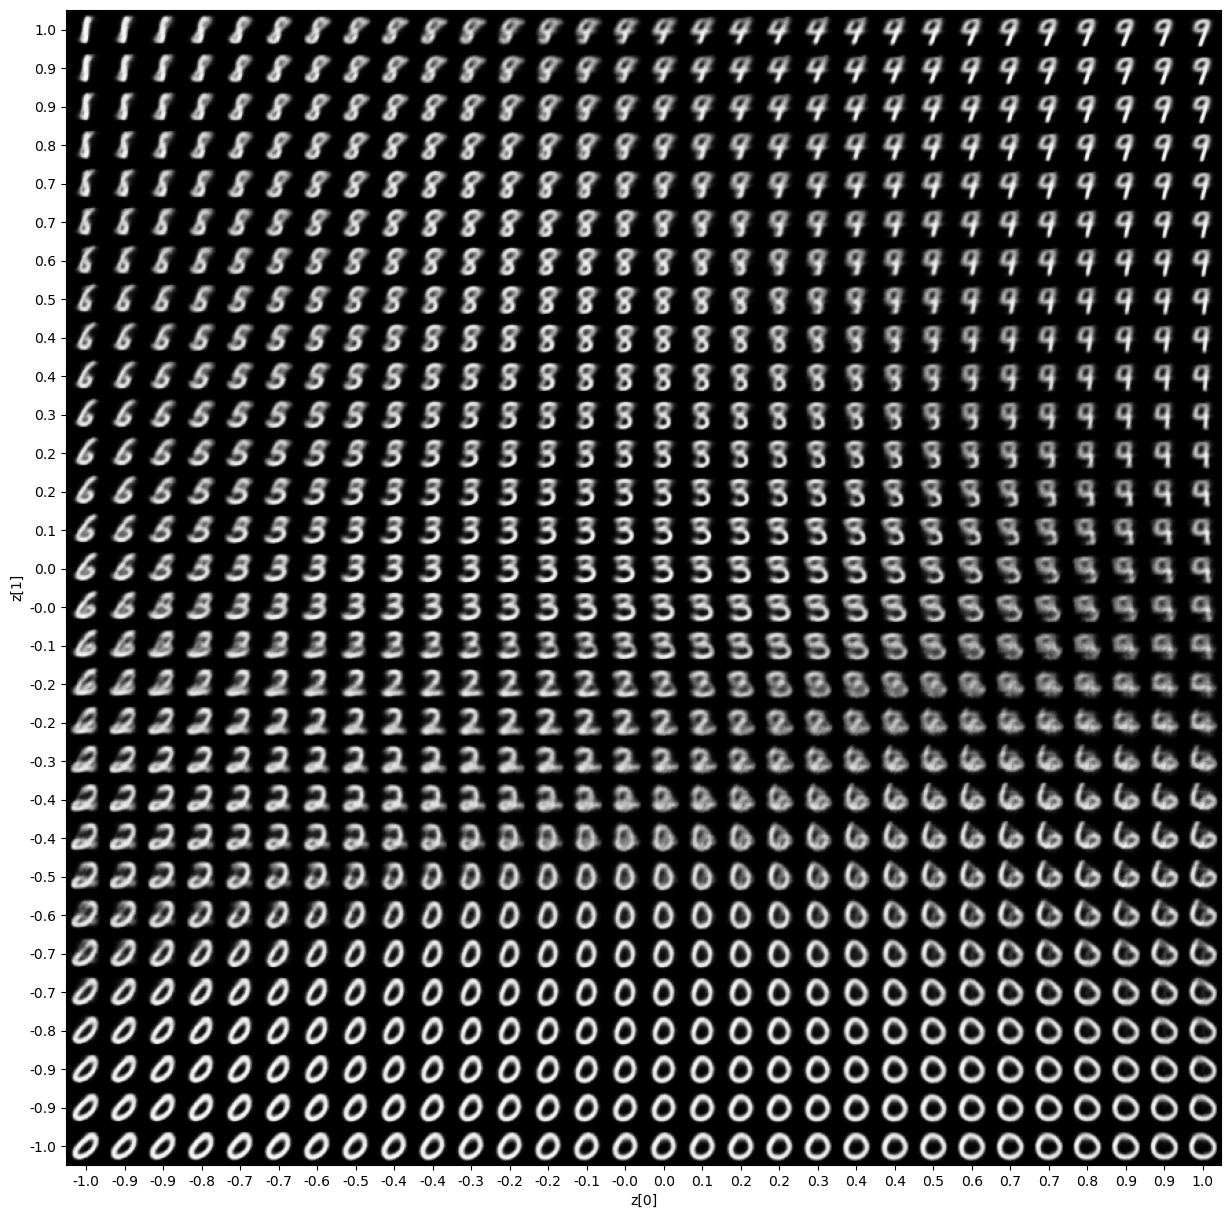

In [12]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample,verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

1875/1875 [==============================] - 7s 3ms/step


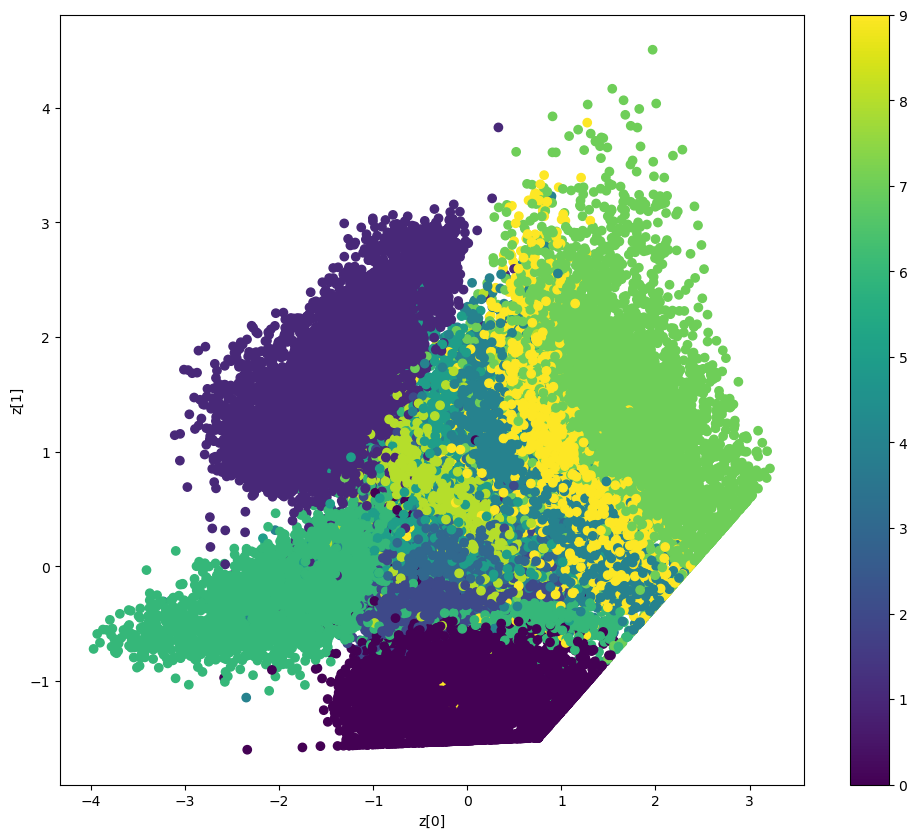

In [13]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

### Discussion

Write down why you design this architecture or why you choose this set of parameter
You should have at least 1 different architectures/set of hyperparameters per person in your team
*Note: For the last step, please turn off a verbose during training

I found this architecture in officail Keras Website. I tried it after use my architecture. My architecture has issue, when i predicted x_test, i found that my model cannot generate other number that reason i change model into currently model. 